In [18]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

dataset = datasets.CIFAR10(root='../../dataset', train=True)

In [4]:
len(dataset)

50000

In [9]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [16]:
dataset[1][1]

9

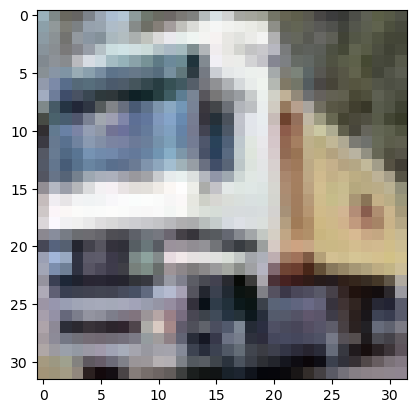

In [17]:
plt.imshow(dataset[1][0])

In [19]:
transform = transforms.Compose([transforms.ToTensor()])
dataset2 = datasets.CIFAR10(root='../../dataset', train=True, transform=transform)

In [20]:
dataset2[0]

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [21]:
from functools import partial
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from model.unet import UNet
from model.diffusion import DiffusionModel
from utils import make_grid

def transform(examples):
    jitter = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
     ])
    image_tensors = [jitter(image.convert("RGB")) for image in examples["image"]]
    return {'img_input': image_tensors}


In [25]:
model = UNet(in_dim=64,
				dim_mults = (1, 2, 4, 8, 16),
				is_attn = (False, False, False, True, True)
				)
diffusion = DiffusionModel(model = model,
							num_timesteps=1_000)

In [26]:
# load data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='../../dataset', train=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=128)
optimizer = torch.optim.AdamW(diffusion.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2000)
diffusion.to(torch.device("cuda"))

DiffusionModel(
  (model): UNet(
    (init_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_emb): TimeEmbedding(
      (ln1): Linear(in_features=64, out_features=256, bias=True)
      (act1): GELU(approximate=none)
      (ln2): Linear(in_features=256, out_features=256, bias=True)
    )
    (downs): ModuleList(
      (0): DownBlock(
        (convres): ConvResBlock(
          (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act1): GELU(approximate=none)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act2): GELU(approximate=none)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (res): Identity()
          (time_ln): Linear(in_features=256, out_features=64, bias=True)
          (time_act): GELU(approximate=none)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (attn): Ident

In [27]:
best_loss = 100
diffusion.load_state_dict(torch.load('lastmodel.pt'))
for epoch in range(1000):
	# train
	print(f"{epoch}th epoch training...")
	loss_total = 0
	for batch_idx, batch in enumerate(tqdm(train_dataloader)):
		data = batch[0].to("cuda")
		optimizer.zero_grad()
		loss = diffusion(data)
		loss.backward()
		optimizer.step()
		loss_total += loss
	train_avg_loss = loss_total/len(train_dataloader)
	print(f"train_loss: {train_avg_loss}, lr: {scheduler.get_last_lr()}")
	loss_total = 0
	scheduler.step()
	# eval
	if train_avg_loss < best_loss:
		best_loss = train_avg_loss
		with torch.no_grad():
			x = diffusion.sample(16,3,128)
		imgs_grid = make_grid(x, 4, 4)
		imgs_grid.save(f"img/{epoch}.png")
		torch.save(diffusion.state_dict(), f"lastmodel.pt")

0th epoch training...


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


train_loss: 0.2723146378993988, lr: [2e-05]


1000it [03:09,  5.27it/s]


1th epoch training...


100%|██████████| 391/391 [02:40<00:00,  2.43it/s]


train_loss: 0.10120228677988052, lr: [1.9999987662997034e-05]


1000it [03:10,  5.25it/s]


2th epoch training...


 30%|██▉       | 117/391 [00:48<01:53,  2.41it/s]